#**Stock Prediction analysis**

##Team: The Mean Squares

1. Jeyasri Subramanian [SJSU ID: 014510132]
2. Subarna Chowdhury Soma [SJSU ID: 014549587]
3. Pranav Lodha [SJSU ID: 009468121]
4. Wasae Qureshi [SJSU ID: 014569880]

##**Contributions:**

1. Financial Statement Data downloading,pre-porcessing and computation **[Subarna & Jeyasri]**
2. Cluster labeled data **[Subarna & Jeyasri]**
3. Linear Regression and Latent Manifold **[ Pranav & Wasae]** 
4. Latent feature computation with income parameters **[Subarna & Jeyasri]**
5. Data insights **[ Pranav & Wasae]**
6. Result Analysis **[Team]**

##**Dataset and Understanding**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture



Mount Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Printing directory details
!ls '/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction'

 all_stocks_date.csv   compressed_financial_stmt.csv
 Assignment-1	       computed_data.csv
 Assignment-2	       computed_results.csv
 Assignment-3	       march_01_2020_complete_data.csv
 Assignment-4	      'Midterm Dataset'
 Assignment-5	       Presentation
 Assignment-6	      'ProjectRecording- March10'
 Assignment-7	      'Project Submission'
 Assignment-8	       stock_summary_data_28_02_2020_16_46_36.csv


#**Data collection and Preparation**


The data downloaded from https://datahub.io/collections/stock-market-data is mapreduced to summarize all stocks data into a single input file


##Load Dataset

In [12]:
financial_stmt_data = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/compressed_financial_stmt.csv', low_memory =False)
financial_stmt_data.tail()

,Date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,stock_name
30335,12/31/2013,197545000.0,0.690586,18810000.0,178735000.0,48498000.0,146810000.0,195684000.0,-16949000.0,0.0,-16564000.0,-4111000.0,0.0,0.0,-12453000.0,0.0,-12453000.0,-0.120,-0.120,117827712.0,108087000.0,0.0,0.9048,0.034,-0.0838,-0.063,0.0468,6690000.0,-16564000.0,-12453000.0,-0.0838,-0.0630,Z
30336,12/31/2012,116850000.0,0.769034,14043000.0,102807000.0,26614000.0,69129000.0,97010000.0,5797000.0,0.0,5939000.0,0.0,0.0,0.0,5939000.0,0.0,5939000.0,0.067,0.060,100299312.0,90582000.0,0.0,0.8798,0.160,0.0508,0.051,0.1679,18712000.0,5939000.0,5939000.0,0.0508,0.0508,Z
30337,12/31/2011,66053000.0,1.168018,10575000.0,55478000.0,14143000.0,40338000.0,54481000.0,997000.0,0.0,0.0,0.0,1102000.0,0.0,0.0,0.0,0.0,0.000,0.000,82681881.0,59445000.0,0.0,0.8399,0.109,0.0000,0.000,0.1081,7190000.0,0.0,1102000.0,0.0000,0.0000,Z
30338,12/31/2010,30467000.0,0.741867,4973000.0,25494000.0,10651000.0,21680000.0,32331000.0,-6837000.0,0.0,-6674000.0,0.0,-100000.0,0.0,-6674000.0,0.0,-6674000.0,-0.177,-0.177,NaN,38310000.0,0.0,0.8368,-0.046,-0.2191,-0.219,-0.0866,-1412000.0,-6674000.0,-6774000.0,-0.2191,-0.2191,Z
30339,12/31/2009,17491000.0,0.651200,4042000.0,13449000.0,11260000.0,15155000.0,26415000.0,-12966000.0,0.0,-12855000.0,0.0,0.0,0.0,-12855000.0,0.0,-12855000.0,-0.340,-0.340,NaN,37839000.0,0.0,0.7689,-0.369,-0.7349,-0.735,-0.4482,-6448000.0,-12855000.0,-12855000.0,-0.7349,-0.7349,Z


In [13]:
# Print types for columns in csv file
print(financial_stmt_data.shape)
financial_stmt_data.dtypes

(30340, 33)


Date                                 object
Revenue                             float64
Revenue Growth                      float64
Cost of Revenue                     float64
Gross Profit                        float64
R&D Expenses                        float64
SG&A Expense                        float64
Operating Expenses                  float64
Operating Income                    float64
Interest Expense                    float64
Earnings before Tax                 float64
Income Tax Expense                  float64
Net Income - Non-Controlling int    float64
Net Income - Discontinued ops       float64
Net Income                          float64
Preferred Dividends                 float64
Net Income Com                      float64
EPS                                 float64
EPS Diluted                         float64
Weighted Average Shs Out            float64
Weighted Average Shs Out (Dil)      float64
Dividend per Share                  float64
Gross Margin                    

In [14]:
# Print unique stock names
financial_stmt_data.stock_name.unique()

array(['AACG', 'AAL', 'AAMC', ..., 'ZYME', 'ZYNE', 'Z'], dtype=object)

In [15]:
# Print count of stocks (ensuring there is only 1)
financial_stmt_data.groupby('stock_name').stock_name.nunique()

stock_name
A       1
AA      1
AACG    1
AAL     1
AAMC    1
       ..
ZTS     1
ZUMZ    1
ZUO     1
ZYME    1
ZYNE    1
Name: stock_name, Length: 3710, dtype: int64

#Data Preprocessing-1

In [16]:
# Printing financial statement data that has null data
financial_stmt_data[financial_stmt_data.isnull().any(axis=1)]

,Date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,stock_name
1,12/31/2017,NaN,0.000000,NaN,16917612.42,NaN,NaN,21320007.47,-4.402395e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.336875e+06,NaN,NaN,NaN,AACG
42,12/31/2012,63421000.0,0.325690,44492000.0,18929000.00,7603000.0,11147000.0,18750000.00,1.790000e+05,1381000.0,-945000.0,0.0,0.0,0.0,-945000.0,0.0,-945000.0,-3.560,-3.560,NaN,265576.0,0.0,0.2985,0.053,0.0069,-0.015,-0.0536,3378000.0,4.360000e+05,-945000.0,-0.0149,-0.0149,AAOI
43,12/31/2011,47840000.0,NaN,34468000.0,13372000.00,6451000.0,10655000.0,17106000.00,-3.734000e+06,1338000.0,-5328000.0,0.0,0.0,0.0,-5328000.0,0.0,-5328000.0,-20.210,-20.210,NaN,263658.0,0.0,0.2795,-0.018,-0.0834,-0.111,-0.1156,-878000.0,-3.990000e+06,-5328000.0,-0.1114,-0.1114,AAOI
73,12/31/2010,117748000.0,0.045849,32208000.0,85540000.00,0.0,8699000.0,43118000.00,4.242200e+07,43251000.0,0.0,0.0,2174000.0,-552000.0,0.0,0.0,0.0,NaN,NaN,39159840.0,39159840.0,0.0,0.7265,0.660,0.3673,0.000,0.3772,77670000.0,4.325100e+07,2174000.0,0.0000,0.0000,AAT
74,12/31/2009,112586000.0,-0.069100,27350000.0,85236000.00,0.0,7023000.0,35496000.00,4.974000e+07,42034000.0,0.0,0.0,5239000.0,-494000.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.7571,0.626,0.3734,0.000,0.3660,70507000.0,4.203400e+07,5239000.0,0.0000,0.0000,AAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30323,12/31/2014,1670000.0,NaN,0.0,1670000.00,10473000.0,3945000.0,14418000.00,-1.274800e+07,9000.0,-12942000.0,0.0,0.0,0.0,-12942000.0,0.0,-12942000.0,-1.770,-1.770,NaN,7323985.0,0.0,1.0000,-7.498,-7.7443,-7.750,-4.2491,-12521000.0,-1.293300e+07,-12942000.0,-7.7497,-7.7497,ZYME
30328,12/31/2014,810012.0,-0.141849,0.0,810012.00,2401406.0,4076339.0,6477745.00,-5.667733e+06,1844.0,-5669577.0,0.0,0.0,0.0,-5669577.0,87954.0,-5757531.0,-6.440,-6.440,NaN,894575.0,0.0,1.0000,-0.620,-6.9971,-0.846,-4.3955,-5640670.0,-5.667733e+06,-5669577.0,-6.9994,-6.9994,ZYNE
30329,12/31/2013,943904.0,NaN,0.0,943904.00,1134041.0,444302.0,1578343.00,-6.344390e+05,2351.0,-636790.0,0.0,0.0,0.0,-636790.0,161834.0,-798624.0,-1.630,-1.630,NaN,490760.0,0.0,1.0000,NaN,-0.6721,NaN,-0.1276,-585047.0,-6.344390e+05,-636790.0,-0.6746,-0.6746,ZYNE
30338,12/31/2010,30467000.0,0.741867,4973000.0,25494000.00,10651000.0,21680000.0,32331000.00,-6.837000e+06,0.0,-6674000.0,0.0,-100000.0,0.0,-6674000.0,0.0,-6674000.0,-0.177,-0.177,NaN,38310000.0,0.0,0.8368,-0.046,-0.2191,-0.219,-0.0866,-1412000.0,-6.674000e+06,-6774000.0,-0.2191,-0.2191,Z


In [17]:
# See how many nulls there are for each column
financial_stmt_data.isnull().sum()

Date                                   0
Revenue                              446
Revenue Growth                      1744
Cost of Revenue                     1018
Gross Profit                         355
R&D Expenses                        1267
SG&A Expense                         888
Operating Expenses                   834
Operating Income                     224
Interest Expense                     829
Earnings before Tax                  577
Income Tax Expense                   812
Net Income - Non-Controlling int    1295
Net Income - Discontinued ops       1295
Net Income                           867
Preferred Dividends                 1295
Net Income Com                       597
EPS                                  845
EPS Diluted                          866
Weighted Average Shs Out            2261
Weighted Average Shs Out (Dil)      1864
Dividend per Share                  1282
Gross Margin                         475
EBITDA Margin                       1696
EBIT Margin     

In [18]:
# Data summary
print('Total stock data ',len(financial_stmt_data.stock_name.unique()))
# Latest date
print(max(financial_stmt_data.Date))
# Earlier date
print(min(financial_stmt_data.Date))

Total stock data  3710
9/30/2019
1/1/2010


## Split Year/Month/Day and Fix Date issue

In [0]:
# Lambda functions to get Year, Month, and Day information into our Dataset
financial_stmt_data['Year']= financial_stmt_data['Date'].map(lambda x: x.split("/")[2] if len(x.split("/"))>2 else x.split("-")[0])
financial_stmt_data['Month']= financial_stmt_data['Date'].map(lambda x: x.split("/")[0] if len(x.split("/"))>2 else x.split("-")[1])
financial_stmt_data['Day']= financial_stmt_data['Date'].map(lambda x: x.split("/")[1] if len(x.split("/"))>2 else '01')


In [20]:
# Print some of the data
financial_stmt_data.tail()

,Date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,stock_name,Year,Month,Day
30335,12/31/2013,197545000.0,0.690586,18810000.0,178735000.0,48498000.0,146810000.0,195684000.0,-16949000.0,0.0,-16564000.0,-4111000.0,0.0,0.0,-12453000.0,0.0,-12453000.0,-0.120,-0.120,117827712.0,108087000.0,0.0,0.9048,0.034,-0.0838,-0.063,0.0468,6690000.0,-16564000.0,-12453000.0,-0.0838,-0.0630,Z,2013,12,31
30336,12/31/2012,116850000.0,0.769034,14043000.0,102807000.0,26614000.0,69129000.0,97010000.0,5797000.0,0.0,5939000.0,0.0,0.0,0.0,5939000.0,0.0,5939000.0,0.067,0.060,100299312.0,90582000.0,0.0,0.8798,0.160,0.0508,0.051,0.1679,18712000.0,5939000.0,5939000.0,0.0508,0.0508,Z,2012,12,31
30337,12/31/2011,66053000.0,1.168018,10575000.0,55478000.0,14143000.0,40338000.0,54481000.0,997000.0,0.0,0.0,0.0,1102000.0,0.0,0.0,0.0,0.0,0.000,0.000,82681881.0,59445000.0,0.0,0.8399,0.109,0.0000,0.000,0.1081,7190000.0,0.0,1102000.0,0.0000,0.0000,Z,2011,12,31
30338,12/31/2010,30467000.0,0.741867,4973000.0,25494000.0,10651000.0,21680000.0,32331000.0,-6837000.0,0.0,-6674000.0,0.0,-100000.0,0.0,-6674000.0,0.0,-6674000.0,-0.177,-0.177,NaN,38310000.0,0.0,0.8368,-0.046,-0.2191,-0.219,-0.0866,-1412000.0,-6674000.0,-6774000.0,-0.2191,-0.2191,Z,2010,12,31
30339,12/31/2009,17491000.0,0.651200,4042000.0,13449000.0,11260000.0,15155000.0,26415000.0,-12966000.0,0.0,-12855000.0,0.0,0.0,0.0,-12855000.0,0.0,-12855000.0,-0.340,-0.340,NaN,37839000.0,0.0,0.7689,-0.369,-0.7349,-0.735,-0.4482,-6448000.0,-12855000.0,-12855000.0,-0.7349,-0.7349,Z,2009,12,31


In [0]:
# Converting at categorical data
financial_stmt_data["stock_name"] = financial_stmt_data["stock_name"].astype('category')
# Creating stock_category column
financial_stmt_data["stock_category"] = financial_stmt_data["stock_name"].cat.codes

In [22]:
# Unique stocks print
financial_stmt_data['stock_name'].unique()

[AACG, AAL, AAMC, AAME, AAOI, ..., ZUMZ, ZUO, ZYME, ZYNE, Z]
Length: 3710
Categories (3710, object): [AACG, AAL, AAMC, AAME, ..., ZUO, ZYME, ZYNE, Z]

#**Data Virtualizations**

Since the data volume is too high, we have included only one particular year data for feature virtualizations


In [23]:
# Narrow down on 'Day','Month','Year','stock_category','Net Profit Margin','Gross Margin','Net Income' columns
financial_stmt_filtered= financial_stmt_data[['Day','Month','Year','stock_category','Net Profit Margin','Gross Margin','Net Income']]
# 2012 data greater than June
financial_stmt_filtered = financial_stmt_filtered[(financial_stmt_filtered.Year == '2012') & (financial_stmt_filtered.Month > '6') ]
financial_stmt_filtered.head()

,Day,Month,Year,stock_category,Net Profit Margin,Gross Margin,Net Income
51,29,9,2012,8,0.266651,0.438712,4.173300e+10
314,30,9,2012,40,-0.007127,0.051332,-5.856700e+07
1087,30,9,2012,138,0.000000,0.000000,-1.059200e+07
1108,30,9,2012,140,0.000000,0.000000,0.000000e+00
1862,30,9,2012,231,0.121446,0.266321,1.167300e+09


##Graph representating multiple combinations of features ( Correlation graph )


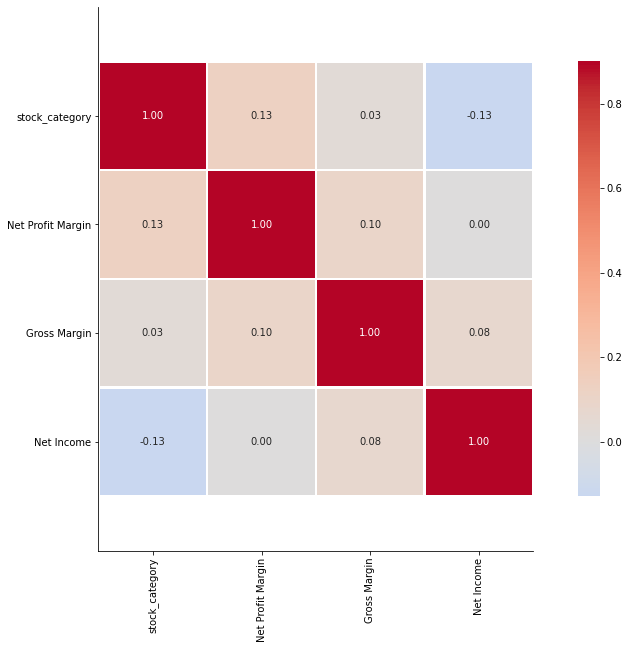

In [24]:
# Basic magic code to do correlation
corr = financial_stmt_filtered.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

#Data Preprocessing-2

## Filter Data - Limit Columns

In [25]:
# Sanity check to see types of the data
financial_stmt_data.dtypes

Date                                  object
Revenue                              float64
Revenue Growth                       float64
Cost of Revenue                      float64
Gross Profit                         float64
R&D Expenses                         float64
SG&A Expense                         float64
Operating Expenses                   float64
Operating Income                     float64
Interest Expense                     float64
Earnings before Tax                  float64
Income Tax Expense                   float64
Net Income - Non-Controlling int     float64
Net Income - Discontinued ops        float64
Net Income                           float64
Preferred Dividends                  float64
Net Income Com                       float64
EPS                                  float64
EPS Diluted                          float64
Weighted Average Shs Out             float64
Weighted Average Shs Out (Dil)       float64
Dividend per Share                   float64
Gross Marg

In [0]:
# Get specified columns from the data
financial_stmt_filtered= financial_stmt_data[['Day','Month','Year','stock_name','stock_category','Net Profit Margin','Gross Margin','Net Income']]

## NaN Detection

In [27]:
# See how many NaN values are there
print(financial_stmt_data.shape)
financial_stmt_filtered.isnull().sum()

(30340, 37)


Day                     0
Month                   0
Year                    0
stock_name              0
stock_category          0
Net Profit Margin    1031
Gross Margin          475
Net Income            867
dtype: int64

In [28]:
# Print rows that have NaN values
financial_stmt_filtered[financial_stmt_filtered.isnull().any(axis=1)]

,Day,Month,Year,stock_name,stock_category,Net Profit Margin,Gross Margin,Net Income
1,31,12,2017,AACG,2,NaN,NaN,NaN
212,31,12,2018,ACAM,26,NaN,NaN,NaN
258,01,12,2018,ACGLO,33,NaN,NaN,758000000.0
259,01,12,2017,ACGLO,33,NaN,NaN,619000000.0
260,01,12,2016,ACGLO,33,NaN,NaN,693000000.0
...,...,...,...,...,...,...,...,...
30146,3,5,2014,YUMC,3684,NaN,NaN,NaN
30291,30,11,2018,ZTR,3704,NaN,2.4977,NaN
30292,31,12,2017,ZTR,3704,NaN,0.8601,NaN
30293,31,12,2016,ZTR,3704,NaN,0.9229,NaN


## NaN Removal

In [0]:
# Drop any stocks where they have NA
financial_stmt_filtered= financial_stmt_filtered.dropna(axis=0, how='any')

Current Stock Count

In [30]:
# After dropping, how many stocks remaining
financial_stmt_filtered.stock_name.unique()

[AACG, AAL, AAMC, AAME, AAOI, ..., ZUMZ, ZUO, ZYME, ZYNE, Z]
Length: 3580
Categories (3580, object): [AACG, AAL, AAMC, AAME, ..., ZUO, ZYME, ZYNE, Z]

##Graph representing feature comparison 


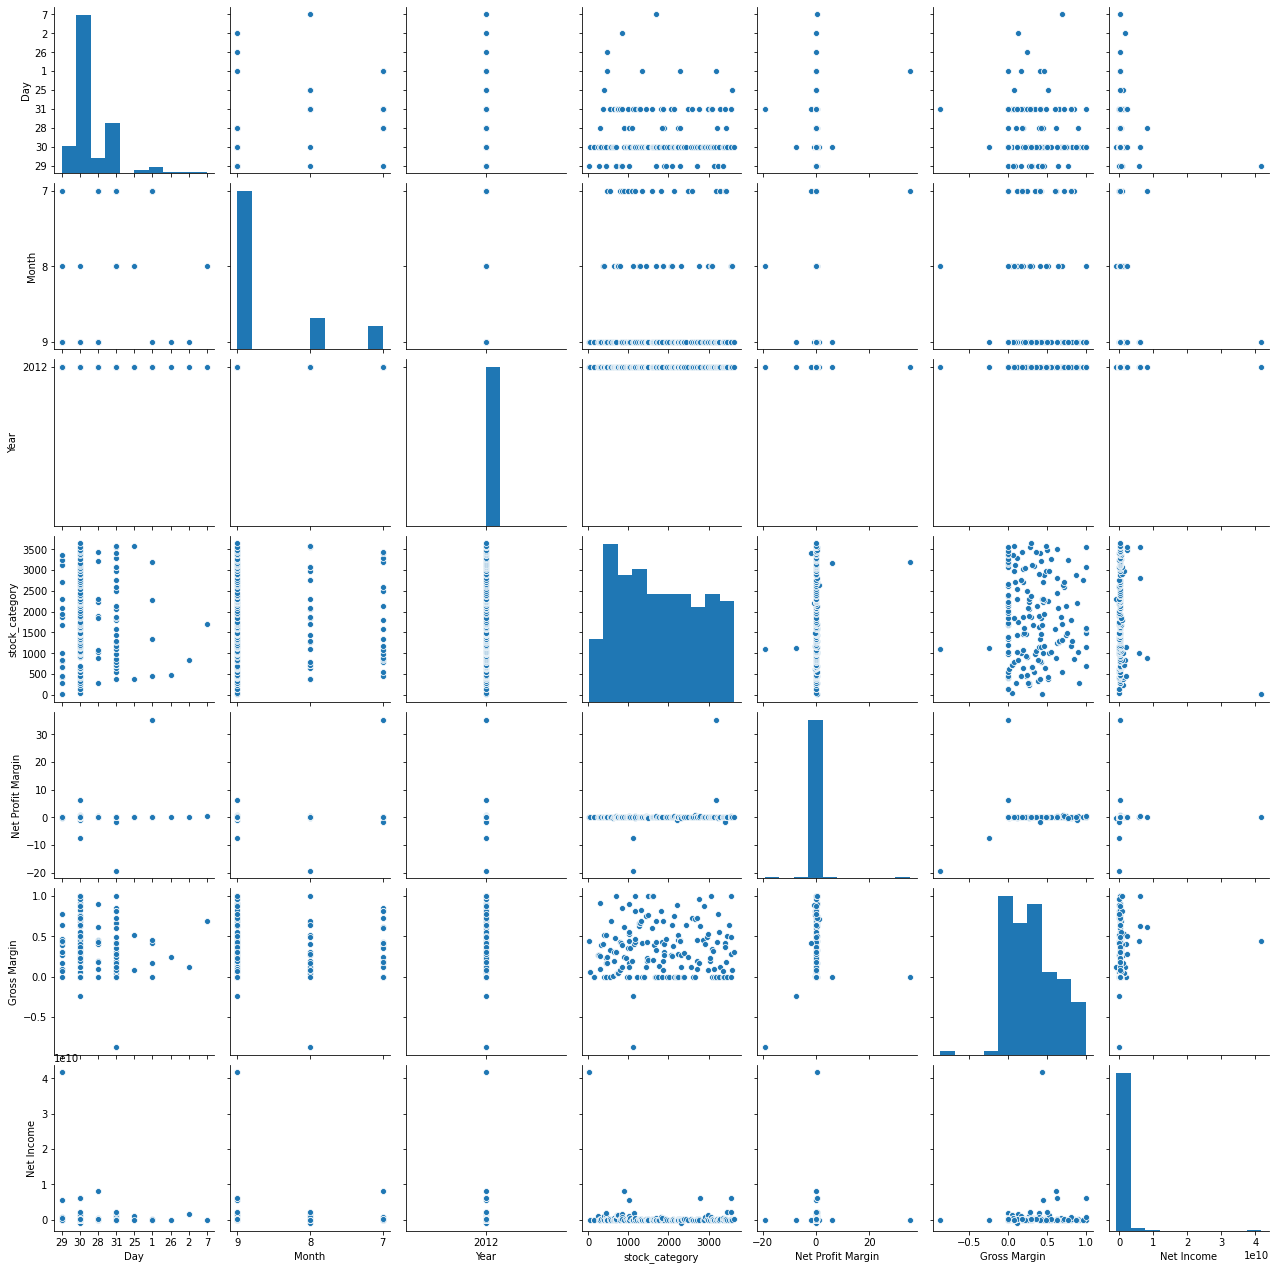

In [31]:
# Plotting pairplot for datset
sns.pairplot(financial_stmt_filtered[(financial_stmt_filtered.Year == '2012') & (financial_stmt_filtered.Month > '6') ])

In [32]:
print("Row Count:",financial_stmt_filtered.shape)
# Printing out cleansed data
financial_stmt_filtered.head()

Row Count: (29309, 8)


,Day,Month,Year,stock_name,stock_category,Net Profit Margin,Gross Margin,Net Income
0,31,12,2018,AACG,2,638.6755,-2.1761,1.237230e+08
2,31,3,2017,AACG,2,-1.1002,0.5010,-1.409955e+06
3,31,3,2016,AACG,2,0.0625,0.5013,4.028326e+06
4,31,3,2015,AACG,2,0.0658,0.5073,3.723469e+06
5,31,3,2014,AACG,2,0.0709,0.5100,4.397297e+06


##Clustering and Labeling (Results from previous Assignments)


In [33]:
# Loading in the original data
computed_data = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/computed_data.csv', low_memory =False)
computed_data.tail()

,stock_name,sector,avg_yearly_returns,yearly_variance
4393,ZUMZ,Consumer-Cyclical,0.214846,0.244304
4394,ZUO,Technology,-0.042532,0.014479
4395,ZYME,Healthcare,0.833954,1.018350
4396,ZYNE,Healthcare,0.034941,0.446001
4397,Z,Communication-Services,0.161969,0.107521


In [34]:
#convert to categorical codes
computed_data['stock_name'] = computed_data['stock_name'].astype('category')
computed_data["stock_code"] = computed_data["stock_name"].cat.codes
computed_data['sector'] = computed_data['sector'].astype('category')
computed_data["sector_code"] = computed_data["sector"].cat.codes
computed_data.tail()

,stock_name,sector,avg_yearly_returns,yearly_variance,stock_code,sector_code
4393,ZUMZ,Consumer-Cyclical,0.214846,0.244304,4394,2
4394,ZUO,Technology,-0.042532,0.014479,4395,10
4395,ZYME,Healthcare,0.833954,1.018350,4396,7
4396,ZYNE,Healthcare,0.034941,0.446001,4397,7
4397,Z,Communication-Services,0.161969,0.107521,4372,1


In [35]:
computed_data.tail()

,stock_name,sector,avg_yearly_returns,yearly_variance,stock_code,sector_code
4393,ZUMZ,Consumer-Cyclical,0.214846,0.244304,4394,2
4394,ZUO,Technology,-0.042532,0.014479,4395,10
4395,ZYME,Healthcare,0.833954,1.018350,4396,7
4396,ZYNE,Healthcare,0.034941,0.446001,4397,7
4397,Z,Communication-Services,0.161969,0.107521,4372,1


In [36]:
filtered_computed_data = computed_data[['sector_code','stock_code','avg_yearly_returns','yearly_variance']]
filtered_computed_data.head()

,sector_code,stock_code,avg_yearly_returns,yearly_variance
0,3,2,0.259259,0.000000
1,8,3,0.374324,0.480449
2,6,4,1.818871,12.961993
3,6,5,0.089031,0.094460
4,10,6,0.136242,0.192417


In [0]:
def gmm_cluster(data_to_fit,n_clusters):
  gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(data_to_fit)
  labels = gmm.predict(data_to_fit)
  gmm_scores = gmm.score_samples(data_to_fit)
  print('Means by sklearn:\n', gmm.means_)
  #print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
  print('Scores by sklearn:\n', gmm_scores[0:20])
  #print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])
  fig, ax = plt.subplots()
  scatter = ax.scatter(data_to_fit[:,0],data_to_fit[:,1], s=150,marker='o',edgecolors='black' ,c = labels, cmap ="rainbow")
   # produce a legend with the unique colors from the scatter
  legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters")
  ax.add_artist(legend1)
  plt.title('GMM Clustering') 
  plt.gcf().set_size_inches(22,8)
  plt.show()

  return labels


In [0]:
def fractal_clustering(data, n_iterations =3,n_clusters=3):
  for i in range(n_iterations):

    plot_cluster(data, max_loop=25)
    first_trial = apply_cluster(data, clusters=n_clusters)
    cluster_perf_df = (
      first_trial
      .groupby('cluster')
      .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "stock_code":"count","sector_code":"count"})
      .sort_values('avg_yearly_returns')
      .reset_index()
    )

    print(cluster_perf_df.head())
    data = first_trial.query("cluster == 0").reset_index(drop=True)
    print(data.head())
  
  return data

In [0]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

In [0]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

(4398, 4)


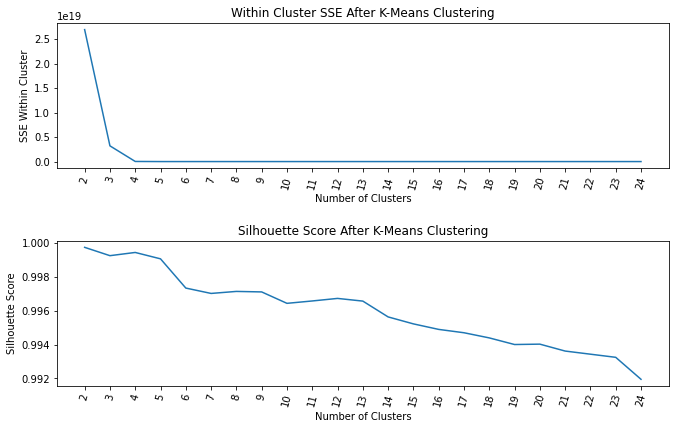

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 160083463027318.0
   cluster  avg_yearly_returns  yearly_variance  stock_code  sector_code
0        0            0.975764     1.213149e+03        4394         4394
1        3         4511.084807     1.824843e+08           1            1
2        4         4930.373870     2.165139e+08           1            1
3        2         9249.818289     7.700474e+08           1            1
4        1        64175.687607     3.592391e+10           1            1
   sector_code  stock_code  avg_yearly_returns  yearly_variance  cluster
0            3           2            0.259259         0.000000        0
1            8           3            0.374324         0.480449        0
2            6           4            1.818871        12.961993        0
3            6           5            0.089031         0.094460        0
4           10           6            0.136242         0.192417        0


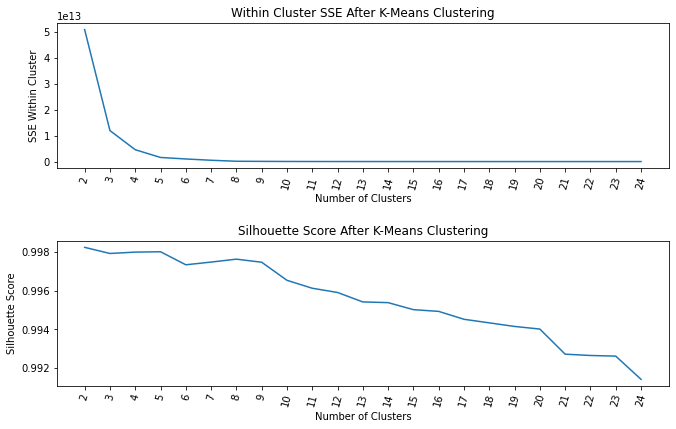

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 1582561166507.0
   cluster  avg_yearly_returns  yearly_variance  stock_code  sector_code
0        0            0.400673     8.464752e+01        4384         4384
1        2          206.894224     2.528539e+05           5            5
2        3          248.670302     4.518634e+05           3            3
3        4          334.820499     7.868967e+05           1            1
4        1          415.652886     1.552728e+06           1            1
   sector_code  stock_code  avg_yearly_returns  yearly_variance  cluster
0            3           2            0.259259         0.000000        0
1            8           3            0.374324         0.480449        0
2            6           4            1.818871        12.961993        0
3            6           5            0.089031         0.094460        0
4           10           6            0.136242         0.192417        0


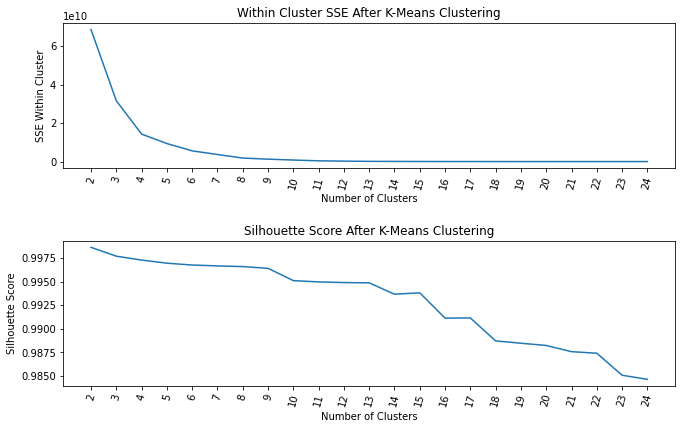

clustering performance
-----------------------------------
silhouette score: 1.0
sse withing cluster: 9383019377.0
   cluster  avg_yearly_returns  yearly_variance  stock_code  sector_code
0        0            0.194993         3.926102        4370         4370
1        4           39.081323      7962.291208           8            8
2        2           64.046893     28119.511925           2            2
3        3           98.214407     64004.842958           2            2
4        1          133.630323     52995.302523           2            2
   sector_code  stock_code  avg_yearly_returns  yearly_variance  cluster
0            3           2            0.259259         0.000000        0
1            8           3            0.374324         0.480449        0
2            6           4            1.818871        12.961993        0
3            6           5            0.089031         0.094460        0
4           10           6            0.136242         0.192417        0


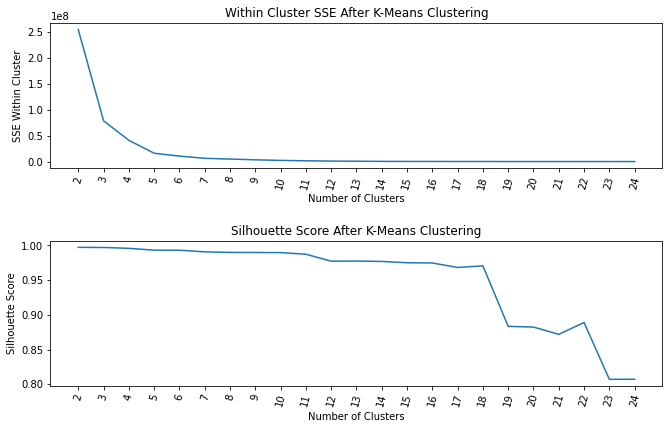

clustering performance
-----------------------------------
silhouette score: 0.99
sse withing cluster: 16098616.0
   cluster  avg_yearly_returns  yearly_variance  stock_code  sector_code
0        0            0.144313         0.482734        4351         4351
1        4            7.349759       245.499137          11           11
2        2           12.552001       968.204336           4            4
3        3           19.728280      3505.896163           1            1
4        1           24.476250      1659.162554           3            3
   sector_code  stock_code  avg_yearly_returns  yearly_variance  cluster
0            3           2            0.259259         0.000000        0
1            8           3            0.374324         0.480449        0
2            6           4            1.818871        12.961993        0
3            6           5            0.089031         0.094460        0
4           10           6            0.136242         0.192417        0


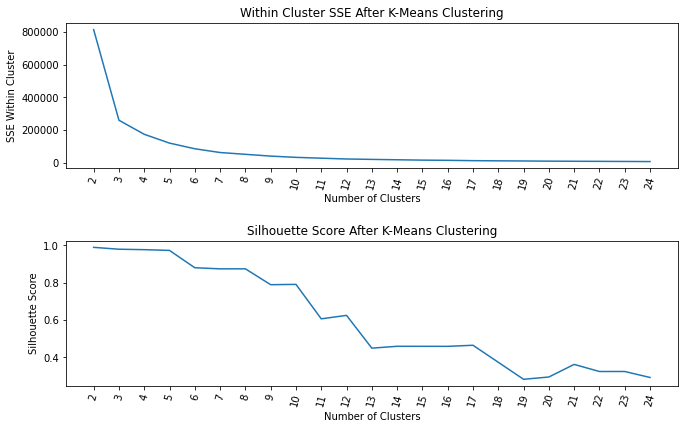

clustering performance
-----------------------------------
silhouette score: 0.97
sse withing cluster: 120936.0
   cluster  avg_yearly_returns  yearly_variance  stock_code  sector_code
0        0            0.126136         0.202358        4321         4321
1        3            1.932895        20.280493          16           16
2        1            3.016633        39.629612           7            7
3        4            4.133467        76.173132           4            4
4        2            4.765634       106.465342           3            3
   sector_code  stock_code  avg_yearly_returns  yearly_variance  cluster
0            3           2            0.259259         0.000000        0
1            8           3            0.374324         0.480449        0
2            6           5            0.089031         0.094460        0
3           10           6            0.136242         0.192417        0
4           10           8            0.298937         0.081963        0


,sector_code,stock_code,avg_yearly_returns,yearly_variance,cluster
0,3,2,0.259259,0.000000,0
1,8,3,0.374324,0.480449,0
2,6,5,0.089031,0.094460,0
3,10,6,0.136242,0.192417,0
4,10,8,0.298937,0.081963,0


In [41]:
print(filtered_computed_data.shape)
clustered_data = fractal_clustering(filtered_computed_data,n_iterations=5,n_clusters=5)
clustered_data.head()

In [0]:
def kmeans_plot(cluster_indices):
   fig, ax = plt.subplots()
   scatter = ax.scatter(data_to_fit[:,2],data_to_fit[:,3], s=150,marker='o',edgecolors='black' ,c = cluster_indices, cmap ="rainbow")

   # produce a legend with the unique colors from the scatter
   legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters")
   ax.add_artist(legend1)
   plt.title('K-Means Clustering') 
   plt.gcf().set_size_inches(22,8)
   plt.show()

In [0]:
def prep_final_data_to_fit(agg_df4):
    stock_names = agg_df4.stock_name.values
    # Dropping stock_name from data to plot
    data_to_fit = agg_df4.copy().drop('stock_name', axis=1)
    #data_to_fit = data_to_fit.copy().drop('cluster', axis=1)

    # Getting data as values for clustering algorithms
    data_to_fit = data_to_fit.values
    print (data_to_fit)
    return data_to_fit

In [0]:
def kmeans_cluster(data_to_fit, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data_to_fit)
    cluster_indices = kmeans.predict(data_to_fit)
    return cluster_indices

In [0]:
def prep_final_data_to_fit(agg_df4):
    # Dropping stock_name from data to plot
    #data_to_fit = data_to_fit.copy().drop('cluster', axis=1)

    # Getting data as values for clustering algorithms
    data_to_fit = agg_df4.values
    print (data_to_fit)
    return data_to_fit

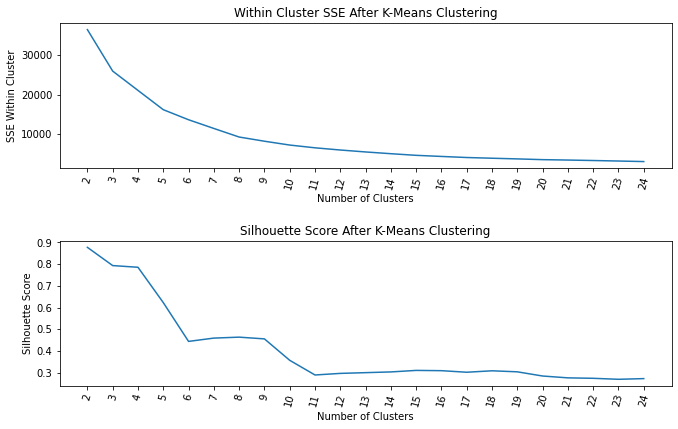

clustering performance
-----------------------------------
silhouette score: 0.62
sse withing cluster: 16199.0


,cluster,avg_yearly_returns,yearly_variance,stock_code,sector_code
0,0,0.079308,0.086424,3816,3816
1,1,0.411570,0.670895,422,422
2,2,0.623806,2.566816,69,69
3,4,1.101663,6.489708,13,13
4,3,11.346939,0.000000,1,1


In [46]:
plot_cluster(clustered_data, max_loop=25)
data_to_fit = clustered_data.copy()
clustered_data = apply_cluster(clustered_data, clusters=5)
cluster_perf_df = (
      clustered_data
      .groupby('cluster')
      .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "stock_code":"count","sector_code":"count"})
      .sort_values('avg_yearly_returns')
      .reset_index()
    )
cluster_perf_df

In [47]:
clustered_data.head()

,sector_code,stock_code,avg_yearly_returns,yearly_variance,cluster
0,3,2,0.259259,0.000000,0
1,8,3,0.374324,0.480449,1
2,6,5,0.089031,0.094460,0
3,10,6,0.136242,0.192417,0
4,10,8,0.298937,0.081963,0


Means by sklearn:
 [[1.13186949e-01 4.03852658e-02]
 [1.41119273e-01 2.22113350e-04]
 [7.51505399e-02 1.91359732e-01]
 [4.18746737e-01 1.32600180e+00]]
Scores by sklearn:
 [ 1.99242539 -1.64327377  1.84873234  0.77015629  0.51118104  1.83571166
  3.41511561  1.4480122  -0.64387     0.78871003  2.56982152  3.44656187
 -4.4034156   0.62398764  0.84878073 -0.72100346  3.58655744  3.14423205
  3.16091039  3.1709131 ]


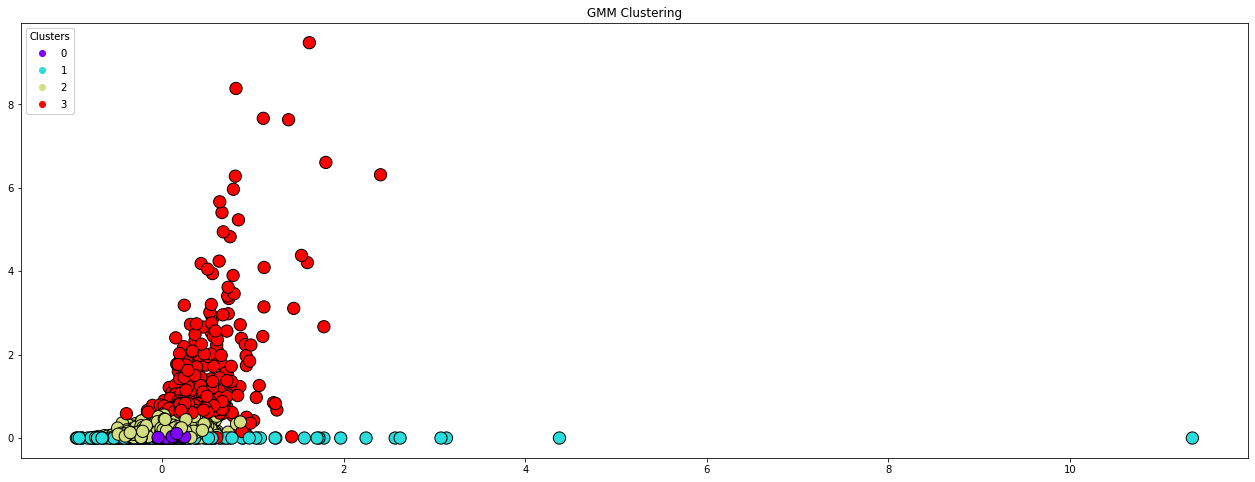

[1 2 0 ... 3 2 0]


,sector_code,stock_code,avg_yearly_returns,yearly_variance,cluster,labels
0,3,2,0.259259,0.000000,0,1
1,8,3,0.374324,0.480449,1,2
2,6,5,0.089031,0.094460,0,0
3,10,6,0.136242,0.192417,0,2
4,10,8,0.298937,0.081963,0,0


In [48]:
data_to_fit = clustered_data.drop(['cluster','sector_code','stock_code'],axis=1)
n_clusters = 4

data2 = data_to_fit.values
labels = gmm_cluster(data2, n_clusters)
print(labels)
clustered_data['labels'] = labels
clustered_data.head()

In [49]:
clustered_data['labels'] = labels
clustered_data.head()

,sector_code,stock_code,avg_yearly_returns,yearly_variance,cluster,labels
0,3,2,0.259259,0.000000,0,1
1,8,3,0.374324,0.480449,1,2
2,6,5,0.089031,0.094460,0,0
3,10,6,0.136242,0.192417,0,2
4,10,8,0.298937,0.081963,0,0


# Original Dataset Linear Regression

In [0]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing

In [51]:
# Print shape of csv file (row and col)
clustered_data.shape

(4321, 6)

In [52]:
columns = ['sector', 'stock_name']

sector_data = computed_data[columns]
#sector_data = computed_data.groupby('stock_name').first().reset_index()
sector_data.head()

,sector,stock_name
0,Consumer-Defensive,AACG
1,Industrials,AAL
2,Financial-Services,AAMC
3,Financial-Services,AAME
4,Technology,AAOI


In [53]:
cluster_labeled_data = pd.concat([clustered_data, sector_data], axis=1, join='inner', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
cluster_labeled_data.head()

,sector_code,stock_code,avg_yearly_returns,yearly_variance,cluster,labels,sector,stock_name
0,3,2,0.259259,0.000000,0,1,Consumer-Defensive,AACG
1,8,3,0.374324,0.480449,1,2,Industrials,AAL
2,6,5,0.089031,0.094460,0,0,Financial-Services,AAMC
3,10,6,0.136242,0.192417,0,2,Financial-Services,AAME
4,10,8,0.298937,0.081963,0,0,Technology,AAOI



#**Linear Regression (where X = Sector for Tech and Industrials   and Y = avg_yearly_returns)**

In [0]:
# Setting X and Y for data
computed_data = cluster_labeled_data.copy()

X = computed_data[['sector_code','stock_code','cluster','yearly_variance']]
Y = computed_data['avg_yearly_returns']
# Y = computed_data.avg_yearly_returns
# X = computed_data.drop("avg_yearly_returns", axis=1)
# X = X.drop("sector", axis=1)
# X = X.drop("stock_name", axis=1)
# Y = Y.reshape(-1, 1)
# Y = np.array(Y).astype(float)



In [0]:
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [0]:
# Fit training data to model
regressor = LinearRegression()  
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

In [57]:
# Calculate Mean Absolute Error, Mean Squared Error, and Root Mean Squared Error.
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))


Mean Absolute Error: 0.13327108211606395
Mean Squared Error: 0.046328816923316474
Root Mean Squared Error: 0.21524129929759409


# Merge Dataset and Find a Latent Manifold 

In [0]:
# Getting unique stock names to iterate through
stocks_in_data = financial_stmt_filtered.stock_name.unique()

In [0]:
import math
def computeAverageReturns(df):
  yearArray = list(df.Year.sort_values().astype('int'))
  net_profit_margin_gain_list = []
  gross_margin_gain_list = []

  net_income_gain_list = []

  for index in range(1,len(yearArray)):
    
    if yearArray[index-1] == yearArray[index] :
       print(index)
       continue
    else:    
      feature_min = df[(df.Year == str(yearArray[index-1]))] [['Net Profit Margin','Gross Margin','Net Income']]
      feature_max = df[(df.Year == str(yearArray[index]))][['Net Profit Margin','Gross Margin','Net Income']]

      if feature_min['Net Profit Margin'].tolist()[0] > 0: gain = (feature_max['Net Profit Margin'].tolist()[0] - feature_min['Net Profit Margin'].tolist()[0])/ feature_min['Net Profit Margin'].tolist()[0]
      else: gain = 0
      net_profit_margin_gain_list.append(gain)
      
      if feature_min['Gross Margin'].tolist()[0] > 0: gain = (feature_max['Gross Margin'].tolist()[0] - feature_min['Gross Margin'].tolist()[0])/ feature_min['Gross Margin'].tolist()[0]
      else: gain = 0
      gross_margin_gain_list.append(gain)
      

      if feature_min['Net Income'].tolist()[0] > 0: gain = (feature_max['Net Income'].tolist()[0] - feature_min['Net Income'].tolist()[0])/ feature_min['Net Income'].tolist()[0]
      else: gain = 0
      net_income_gain_list.append(gain)

  net_profit_margin_average_yearly_returns = np.mean(net_profit_margin_gain_list)
  net_profit_margin_yearly_variance = np.var(net_profit_margin_gain_list)

    
  gross_margin_average_yearly_returns = np.mean(gross_margin_gain_list)
  gross_margin_yearly_variance = np.var(gross_margin_gain_list)

    
  net_income_average_yearly_returns = np.mean(net_income_gain_list)
  net_income_yearly_variance = np.var(net_income_gain_list)

  return net_profit_margin_average_yearly_returns,net_profit_margin_yearly_variance,\
           gross_margin_average_yearly_returns,gross_margin_yearly_variance,\
           net_income_average_yearly_returns,net_income_yearly_variance
 

In [60]:
financial_stmt_filtered.head()

,Day,Month,Year,stock_name,stock_category,Net Profit Margin,Gross Margin,Net Income
0,31,12,2018,AACG,2,638.6755,-2.1761,1.237230e+08
2,31,3,2017,AACG,2,-1.1002,0.5010,-1.409955e+06
3,31,3,2016,AACG,2,0.0625,0.5013,4.028326e+06
4,31,3,2015,AACG,2,0.0658,0.5073,3.723469e+06
5,31,3,2014,AACG,2,0.0709,0.5100,4.397297e+06


In [61]:
lst = []

with open('computed_dataset2.csv', 'w') as csvfile:
    csvfile.write('stock_name,net_profit_AYR,net_profit_YV,gross_margin_AYR,gross_margin_YV,net_income_AYR,net_income_YV,\n')
    for index in range(0,len(stocks_in_data)): #len(stocks_in_data)
          stockName = stocks_in_data[index] 
          #print('stockname: ',stockName)
          rows = []
          rows.append(stockName)    
          single_stock = financial_stmt_filtered[financial_stmt_filtered['stock_name'] == stockName]
          net_profit_margin_average_yearly_returns,net_profit_margin_yearly_variance,\
              gross_margin_average_yearly_returns,gross_margin_yearly_variance,\
              net_income_average_yearly_returns,net_income_yearly_variance = computeAverageReturns(single_stock)
          rows.append(net_profit_margin_average_yearly_returns)
          rows.append(net_profit_margin_yearly_variance)
          rows.append(gross_margin_average_yearly_returns)
          rows.append(gross_margin_yearly_variance)
          rows.append(net_income_average_yearly_returns)
          rows.append(net_income_yearly_variance) 
          csvfile.write(str(stockName)+','+str(net_profit_margin_average_yearly_returns)+','+str(net_profit_margin_yearly_variance)+\
                        ','+str(gross_margin_average_yearly_returns)+','+str(gross_margin_yearly_variance)+','+\
                        str(net_income_average_yearly_returns)+','+str(net_income_yearly_variance)+'\n')    
          lst.append(rows)

computed_dataframe = pd.DataFrame(lst,index=None,columns=['stock_name','net_profit_AYR','net_profit_YV','gross_margin_AYR','gross_margin_YV','net_income_AYR','net_income_YV'])
computed_dataframe.head()      

2
7


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4
4
2
3
2
7
1
4
8
3
5
7
9
11
13
4
4
1
5
2
2
7
5
1
7
5
7
9
11
13
3
8
2
7
7
4
6
8
10
12
1
3
3
2
3
8
2
7
6
7
8
5
2
4
6
4
6
8
10
12
3
8
4
6
6
8
10
12
14
2
7
4
6
8
10
12
2
7
3
3
5
7
9
11
3
5
7
9
11
3
5
7
9
11
3
5
7
9
11
3
5
7
9
11
1
4
7
8
3
8
2
7
7
2
7
5
3
8
8
2
7
3
5
7
9
11
13
5
7
9
11
13
6
1
6
3
8
5
10
6
2
7
2
5
7
8
9
11
12
13
1
7
1
8
1
4
1
7
2
7
2
2
7
4
5
7
8
10
11
13
6
6
2
8
4
4
3
7
3
5
7
9
11
2
6
8
4
6
8
10
12
3
2
4
6
8
8
1
5
4
2
2
7
2
7
5
2
7
2
7
10
10
2
2
9
3
8
8
9
2
7
2
7
3
7
4
7
3
8
10
2
7
7
9
2
4
4
5
4
7
3
4
6
7
2
7
7
1
3
5
7
9
2
4
6
8
10
2
4
6
8
10
7
2
7
3
2
7
3
5
7
9
11
3
5
7
9
11
3
5
7
9
11
3
1
2
7
6
2
8
2
7
3
8
1
4
6
6
9
5
6
3
4
6
3
4
10
3
6
2
4
6
8
4
6
8
10
12
4
6
8
10
12
9
5
6
8
9
10
12
13
14
5
6
7
9
10
3
4
5
5
6
1
3
5
7
2
7
3
2
9
5
6
8
10
12
14
7
2
2
7
4
3
5
7
9
11
5
7
9
11
13
6
2
7
2
3
4
1
6
5
3
2
7
5
7
9
11
13
8
3
5
7
9
11
1
6
8
9
11
3
8
7
4
2
3
8
4
9
12
5
7
9
12
2
6
8
8
8
3
8
3
7
4
2
1
7
3
5
8
10
8
4
6
8
10
2
7
6
4
6
8
10
12
1
3
5
8
10
2
6
2
2
7
1
8
5
8
12
5
5
7
9
5
3
5


,stock_name,net_profit_AYR,net_profit_YV,gross_margin_AYR,gross_margin_YV,net_income_AYR,net_income_YV
0,AACG,-2.220763,38.635189,-0.658494,3.139138,0.014610,0.746884
1,AAL,0.054013,0.403439,-0.087226,0.118282,0.049454,0.359946
2,AAMC,-0.218812,0.191514,-0.254080,0.145570,-0.211026,0.178127
3,AAME,0.183065,0.785155,-0.035507,0.006873,0.301298,1.030385
4,AAOI,0.201711,0.419912,0.035942,0.025516,0.536071,0.973559


In [0]:
# Copied overall_change from https://www.geeksforgeeks.org/overall-percentage-change-from-successive-changes/
# Python implementation of above approach 
def overall_change(arr, N): 
    result = 0; 
  
    var1 = arr[0]; 
    var2 = arr[1]; 
    
    # Calculate successive change of 1st 2 change 
    result = float(var1 + var2 + 
            (float(var1 * var2) / 100)); 
  
    # Calculate successive change 
    # for rest of the value 
    for i in range(2, N): 
        result = (result + arr[i] +
                 (float(result * arr[i]) / 100)); 
        
    return result; 


In [0]:
# Store results
manifold_data = pd.DataFrame(columns=['stock_name', 'percent_change_net_income', 'percent_change_net_profit_margin', 'percent_change_gross_margin'])
results = {}
# In case any failed, skip them for now
nums_failed = 0

for stock in stocks_in_data:
  
  try:
    # Get all stock data prevelant to stock we are looping on
    specific_financial_stock_data = financial_stmt_filtered[financial_stmt_filtered.stock_name == stock]
    # Get number of years of data we have on stock
    i = len(specific_financial_stock_data) - 1
    
    previous_net_profit = None
    net_profit_percent_change = []
    
    previous_gross_margin = None
    gross_margin_percent_change = []

    previous_net_income = None
    net_income_percent_change = []

    # Starting backwards (from 2010 -> ...), calculating percent change from each year for Net Income
    while i >= 0:
      # Get cur_net_income Net Income
      cur_net_profit = specific_financial_stock_data.iloc[i]['Net Profit Margin']
      cur_gross_margin = specific_financial_stock_data.iloc[i]['Gross Margin']
      cur_net_income = specific_financial_stock_data.iloc[i]['Net Income']
      
      # Initial check
      if previous_net_profit:
        # Calculate Percent change
        result = (cur_net_profit - previous_net_profit)/abs(previous_net_profit) 
        net_profit_percent_change.append(result * 100) 
      
      # Initial check
      if previous_gross_margin:
        # Calculate Percent change
        result = (cur_gross_margin - previous_gross_margin)/abs(previous_gross_margin) 
        gross_margin_percent_change.append(result * 100)

      # Initial check
      if previous_net_income:
        # Calculate Percent change
        result = (cur_net_income - previous_net_income)/abs(previous_net_income) 
        net_income_percent_change.append(result * 100) 
      
      i = i - 1
      previous_net_profit = cur_net_profit
      previous_gross_margin = cur_gross_margin
      previous_net_income = cur_net_income

    # Calling overall_change which we got from a different website to see how a stock performed
    o_c_net_profit = (overall_change(net_profit_percent_change, len(net_profit_percent_change)))
    o_c_gross_margin = (overall_change(gross_margin_percent_change, len(gross_margin_percent_change)))
    o_c_net_income = (overall_change(net_income_percent_change, len(net_income_percent_change)))
    
    manifold_data = manifold_data.append({'stock_name' : stock, 'percent_change_net_profit_margin': o_c_net_profit, 'percent_change_gross_margin' : o_c_gross_margin,'percent_change_net_income' : o_c_net_income}, ignore_index=True)
  except:
    nums_failed = nums_failed + 1

In [64]:
manifold_data.head()


,stock_name,percent_change_net_income,percent_change_net_profit_margin,percent_change_gross_margin
0,AACG,-10934.363124,-2.416153e+06,-561.624947
1,AAL,276.411934,2.318338e+02,-100.000000
2,AAMC,-109.450979,-4.002853e+01,-100.000000
3,AAME,-300.548651,-2.137459e+02,-30.154357
4,AAOI,-336.027178,-2.392218e+02,17.411915


In [0]:
cldc = cluster_labeled_data.copy()
results = pd.merge(cldc, manifold_data[['stock_name', 'percent_change_net_income', 'percent_change_net_profit_margin','percent_change_gross_margin']], on='stock_name')


In [66]:
# merging computed results of second dataset with manifold and first dataset
computed_results = pd.merge(computed_dataframe, results, on='stock_name')
computed_results.head()

,stock_name,net_profit_AYR,net_profit_YV,gross_margin_AYR,gross_margin_YV,net_income_AYR,net_income_YV,sector_code,stock_code,avg_yearly_returns,yearly_variance,cluster,labels,sector,percent_change_net_income,percent_change_net_profit_margin,percent_change_gross_margin
0,AACG,-2.220763,38.635189,-0.658494,3.139138,0.014610,0.746884,3,2,0.259259,0.000000,0,1,Consumer-Defensive,-10934.363124,-2.416153e+06,-561.624947
1,AAL,0.054013,0.403439,-0.087226,0.118282,0.049454,0.359946,8,3,0.374324,0.480449,1,2,Industrials,276.411934,2.318338e+02,-100.000000
2,AAMC,-0.218812,0.191514,-0.254080,0.145570,-0.211026,0.178127,6,5,0.089031,0.094460,0,0,Financial-Services,-109.450979,-4.002853e+01,-100.000000
3,AAME,0.183065,0.785155,-0.035507,0.006873,0.301298,1.030385,10,6,0.136242,0.192417,0,2,Financial-Services,-300.548651,-2.137459e+02,-30.154357
4,AAOI,0.201711,0.419912,0.035942,0.025516,0.536071,0.973559,10,8,0.298937,0.081963,0,0,Technology,-336.027178,-2.392218e+02,17.411915


In [67]:
computed_results.dtypes

stock_name                            object
net_profit_AYR                       float64
net_profit_YV                        float64
gross_margin_AYR                     float64
gross_margin_YV                      float64
net_income_AYR                       float64
net_income_YV                        float64
sector_code                             int8
stock_code                             int16
avg_yearly_returns                   float64
yearly_variance                      float64
cluster                                int32
labels                                 int64
sector                              category
percent_change_net_income            float64
percent_change_net_profit_margin     float64
percent_change_gross_margin          float64
dtype: object

##Feature Engineering after merging datasets

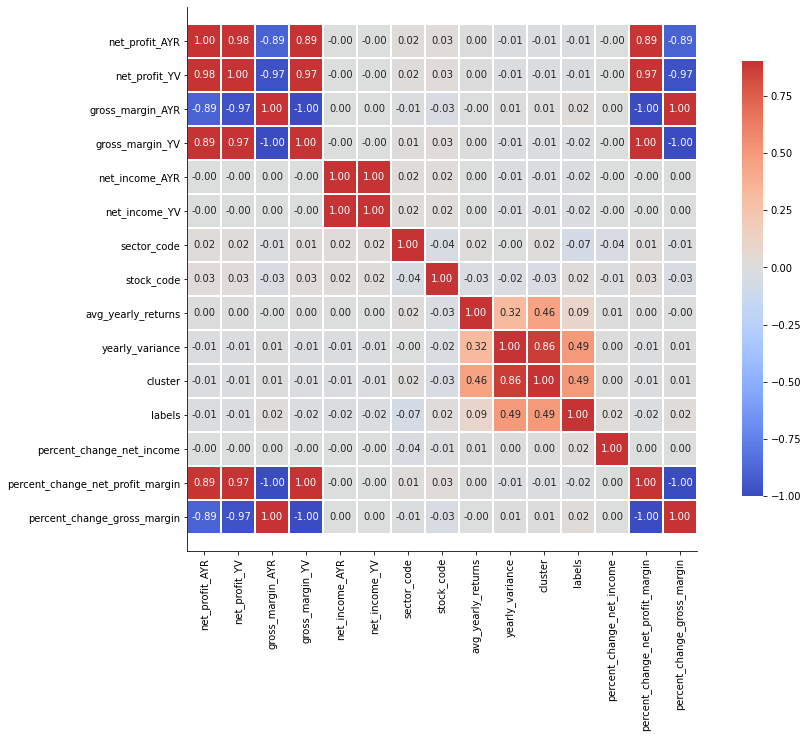

In [68]:
corr = computed_results.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=.9, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

# Linear Regression on Dataset with Manifold

In [0]:
computed_results_ = computed_results.copy()


In [70]:
# dropping columns based on correlation plot
computed_results = computed_results.drop(['gross_margin_AYR','gross_margin_YV','percent_change_gross_margin','percent_change_net_profit_margin','net_profit_YV','net_income_YV'],axis=1)
computed_results.head()

,stock_name,net_profit_AYR,net_income_AYR,sector_code,stock_code,avg_yearly_returns,yearly_variance,cluster,labels,sector,percent_change_net_income
0,AACG,-2.220763,0.014610,3,2,0.259259,0.000000,0,1,Consumer-Defensive,-10934.363124
1,AAL,0.054013,0.049454,8,3,0.374324,0.480449,1,2,Industrials,276.411934
2,AAMC,-0.218812,-0.211026,6,5,0.089031,0.094460,0,0,Financial-Services,-109.450979
3,AAME,0.183065,0.301298,10,6,0.136242,0.192417,0,2,Financial-Services,-300.548651
4,AAOI,0.201711,0.536071,10,8,0.298937,0.081963,0,0,Technology,-336.027178


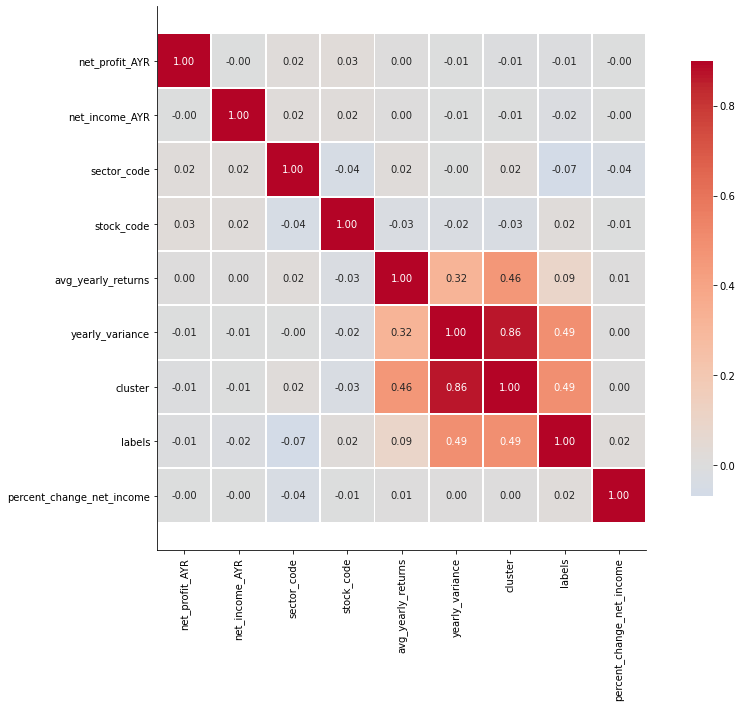

In [71]:
corr = computed_results.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=.9, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

In [72]:
# Setting X and Y for data
computed_data_just_for_two = computed_results #results

#X = computed_data_just_for_two[['sector_code','stock_code','cluster','yearly_variance', 'percent_change_net_income', 'percent_change_net_profit_margin', 'percent_change_gross_margin']]
X = computed_data_just_for_two.drop('sector',axis=1)
X = X.drop('avg_yearly_returns',axis=1)
X = X.drop('stock_name',axis=1)
Y = computed_data_just_for_two['avg_yearly_returns']

X.head()

,net_profit_AYR,net_income_AYR,sector_code,stock_code,yearly_variance,cluster,labels,percent_change_net_income
0,-2.220763,0.014610,3,2,0.000000,0,1,-10934.363124
1,0.054013,0.049454,8,3,0.480449,1,2,276.411934
2,-0.218812,-0.211026,6,5,0.094460,0,0,-109.450979
3,0.183065,0.301298,10,6,0.192417,0,2,-300.548651
4,0.201711,0.536071,10,8,0.081963,0,0,-336.027178


In [73]:
X.shape

(2955, 8)

In [0]:
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [0]:
# Fit training data to model
regressor = LinearRegression()  
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

In [76]:
score = regressor.score(X_train, Y_train)
score

0.26880537507218494

In [77]:
score = regressor.score(X_test, Y_test)
score

-0.5633212590232612

In [78]:
from sklearn.metrics import confusion_matrix
y_test = np.asarray(Y_test, dtype="int")
y_pred = np.asarray(Y_pred, dtype='int')
confusion_matrix(y_test, y_pred)

array([[584,   2,   0,   1],
       [  3,   0,   0,   0],
       [  1,   0,   0,   0],
       [  0,   0,   0,   0]])

In [79]:
# Calculate Mean Absolute Error, Mean Squared Error, and Root Mean Squared Error.
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

Mean Absolute Error: 0.15819548697074437
Mean Squared Error: 0.09690147220557202
Root Mean Squared Error: 0.3112900130193258


# Interpretation

## Dataset 1 Analysis

From the previous assignment results, we have considered both K-means and GMM clustering result as labelled data to the existing dataset. In this dataset we decided to use the stock name, stock sector, clustering label, and average yearly variance in order to predict the average yearly return. We found that the Root Mean squared error showed the slippage pretty accurately.


The Mean Squared Error came out to 4.6%. This would mean the total amount of risk associated with the transaction would be relatively low. Using the Mean squared error we calculated the root mean squared error, which came out to 21%, showing that the slippage would not be that large. For example, if we were to predict that the average return would be 50%, but in reality it was 30%, our slippage would be 20%. Having this small of a slippage gives us confidence in predicting the average yearly returns for each stock. 


## Latent Manifold Feature Analysis

For second dataset we have incorporated Financial fundamental information of stocks. 
We have identified net margin, gross income, net profit margin and profit margin as key features from the second dataset. We did the initial feature engineering and identified profit margin and net profit margin has 1.0 correlation, hence we continued with the other three features.

We did computed the following additional metrics:
1. percent change in net income
2. percent change in profit margin
3. percent change in gross income 
4. average yearly net income
5. average yearly profit margin 
6. average yearly gross margin
7. yearly variance on net income
8. yearly variance on profit margin
9. yearly variance on gross margin

Initally, we did correlation on the features and removed features with high correlation. We have applied linear regression on the amalgamation data to predict the yearly returns of the stock. 

What we learned was that our mean squared error and root mean squared error decreased a bit with the introduction of our Latent Manifold. The manifold of percent change net income, helped reduce our mean squared error to 3.9% and our Root mean squared error 19.8%. Adding features to linear model, increased error by 4%

This would imply that we would be closer to our line of best fit, based on our mean squared error. Predicting our average yearly returns would be much more accurate. 

## Additional Feature Engineering

After running Linear Regression on our merged dataset, we decided to go a bit further and explore what the affect of adding more features to our dataset would have. This increased our root mean squared error to 28%. We noticed that we did not have that great corellation. 

The only good correlation that we saw as between the cluster and yearly variance, which we should have expected since the clusters were based on the yearly varaince and yearly returns. 

This reduction in our models preformance shows us that adding more features does not always work and this is a perfect example of overfitting. 

An increase slippage is showing us that we need to imporve our features in-order to proerply predict the yearly returns and become much more risk averse. 

### Clustering analysis

We did applied clustering for average_yearly_returns and yearly_variance. From silhoutee score, we have tried with 6 clusters. Cluster 0 formed with 4781 stocks, whereas other clusters are splitted with 1 stock each This result is not sufficient for us to continue the work.
Hence we tried continuing the clustering process for 5 iterations, until we have some meaningful grouping of data. Clustering process with one iteration doesn't group any data for average variance and yearly returns, whereas 5 iterations helped us to group data as follows


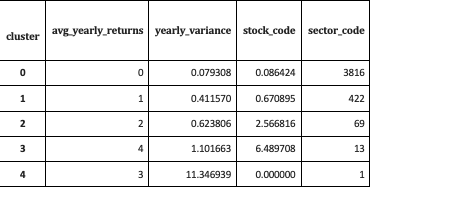


This grouping splitted the data into meaningful range of 'Average yearly returns' and 'Annual variance'. From fractal clustering, we were able to filter 500+ stocks from further processing, as these stocks are more volatile.

# Reference

1. http://andrewilardi.com/2017/12/slippage-root-mean-squared-error-model-performance/
2. https://en.wikipedia.org/wiki/Mean_absolute_error
3. https://en.wikipedia.org/wiki/Root-mean-square_deviation
4. https://en.wikipedia.org/wiki/Mean_squared_error
5. https://medium.com/@ewuramaminka/mean-absolute-error-mae-sample-calculation-6eed6743838a
6. https://www.statisticshowto.datasciencecentral.com/rmse/
7. https://www.statisticshowto.datasciencecentral.com/mean-squared-error/
8. https://gisgeography.com/root-mean-square-error-rmse-gis/ 
9. https://www.geeksforgeeks.org/overall-percentage-change-from-successive-changes/
